# Defining the business metrics


- A) Reduce False Positives (FP) rather than False Negatives (FN).
- B) Reduce False Negatives (FN) rather than False Positives (FP).

In this project, We assumed that the best case for the business was **option (B)**, that is, **a default on a loan is worse that not giving a loan to a person**.

# Loading the data set

In [11]:
import itc_utils.flight_service as itcfs

readClient = itcfs.get_flight_client()

nb_data_request = {
    'data_name': """credit_risk_dataset_sb.csv""",
    'interaction_properties': {
        #'row_limit': 500,
        'infer_schema': 'true'
    }
}

flightInfo = itcfs.get_flight_info(readClient, nb_data_request=nb_data_request)

data_df_1 = itcfs.read_pandas_and_concat(readClient, flightInfo)
data_df_1.head(10)

df_cr_loan = data_df_1
df_cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,True,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,False,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,True,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,True,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,True,0.55,Y,4


In [12]:
# checks the structure of the data set
df_cr_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int32  
 1   person_income               32581 non-null  int32  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int32  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  bool   
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int32  
dtypes: bool(1), float64(3), int32(4), object(4)
memory usage: 2.3+ MB


## 4.3 Descriptive statistics

In [22]:
# creates a dataset for numerical attributes
num_attributes = df_cr_loan.select_dtypes(include=['int32', 'float64', 'bool'])

# creates a dataset for categorical attributes
cat_attributes = df_cr_loan.select_dtypes(exclude=['int32', 'float64', 'bool'])

In [23]:
# checks the operation
num_attributes.sample(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
18610,30,175000,1.0,18000,5.79,False,0.10,10
32157,36,60000,2.0,15000,NaN,False,0.25,12


In [24]:
# checks the operation
cat_attributes.sample(2)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
19596,MORTGAGE,MEDICAL,B,N
10002,MORTGAGE,HOMEIMPROVEMENT,C,N


In [32]:
import numpy as np
# central tendency: mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_value = pd.DataFrame(num_attributes.apply(min)).T
max_value = pd.DataFrame(num_attributes.apply(max)).T
#range_value = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
range_value = pd.DataFrame(num_attributes.apply(lambda x: np.subtract(x.max(),x.min(), dtype=np.float32))).T
skewness = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenates
summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
summary_stats.columns = ['attributes','min','max','range','mean','median','std','skewness','kurtosis']

In [33]:
# checks the operations
summary_stats

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,person_age,20,144,124.0,27.7346,26.0,6.347981,2.581393,18.560825
1,person_income,4000,6000000,5996000.0,66074.84847,55000.0,61982.167945,32.865349,2693.272776
2,person_emp_length,0.0,123.0,123.0,4.789686,NaN,4.142565,2.614455,43.722338
3,loan_amnt,500,35000,34500.0,9589.371106,8000.0,6321.989624,1.192477,1.423565
4,loan_int_rate,5.42,23.22,17.799999,11.011695,NaN,3.240404,0.20855,-0.671609
5,loan_status,False,True,1.0,0.218164,0.0,0.412999,1.364888,-0.137088
6,loan_percent_income,0.0,0.83,0.83,0.170203,0.15,0.10678,1.064669,1.223687
7,cb_person_cred_hist_length,2,30,28.0,5.804211,4.0,4.054939,1.66179,3.716194


As observed, we can notice the presence of outliers in `person_age` (`max = 144`) and `person_emp_length` (`max = 123`).

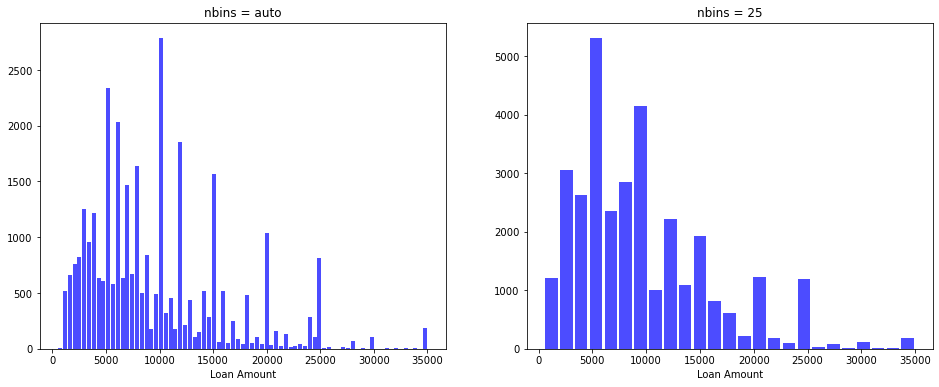

In [34]:
# looks at the distribution of loan amounts with a histogram
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
n, bins, patches = plt.hist(x=df_cr_loan['loan_amnt'], bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.title("nbins = auto")
plt.xlabel("Loan Amount")

plt.subplot(1,2,2)
n, bins, patches = plt.hist(x=df_cr_loan['loan_amnt'], bins=25, color='blue', alpha=0.7, rwidth=0.85)
plt.title("nbins = 25")
plt.xlabel("Loan Amount")

plt.show()

### 4.3.1 Categorical attributes

In [35]:
# checks how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64

### 4.3.2 Crosstab and pivot tables

In [36]:
# creates a cross table of the loan intent and loan status
pd.crosstab(df_cr_loan['loan_intent'], df_cr_loan['loan_status'], margins=True)

loan_status,False,True,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5342,1111,6453
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4423,1098,5521
VENTURE,4872,847,5719
All,25473,7108,32581


In [37]:
# creates a cross table of home ownership, loan status, and grade
pd.crosstab(df_cr_loan['person_home_ownership'], [df_cr_loan['loan_status'], df_cr_loan['loan_grade']], 
            margins=True)

loan_status           False                                True              \
loan_grade                A     B     C     D    E   F  G     A     B     C   
person_home_ownership                                                         
MORTGAGE               5219  3729  1934   658  178  36  0   239   324   321   
OTHER                    23    29    11     9    2   0  0     3     5     6   
OWN                     860   770   464   264   26   7  0    66    34    31   
RENT                   3602  4222  2710   554  137  28  1   765  1338   981   
All                    9704  8750  5119  1485  343  71  1  1073  1701  1339   

loan_status                                  All  
loan_grade                D    E    F   G         
person_home_ownership                             
MORTGAGE                553  161   61  31  13444  
OTHER                    11    6    2   0    107  
OWN                      18   31    8   5   2584  
RENT                   1559  423   99  27  16446  
All                    2141  621  170  63  32581

In [39]:
# creates a cross table of home ownership, loan status, and average percent income
pd.crosstab(df_cr_loan['person_home_ownership'], df_cr_loan['loan_status'],
              values=df_cr_loan['loan_percent_income'], aggfunc='mean')

loan_status,False,True
person_home_ownership,,
MORTGAGE,0.146504,0.184882
OTHER,0.143784,0.300000
OWN,0.180013,0.297358
RENT,0.144611,0.264859


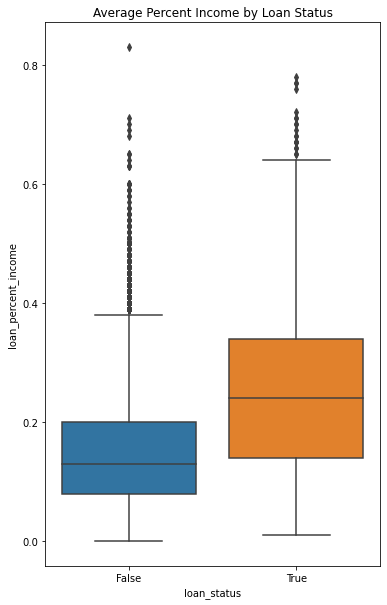

In [40]:
# creates a box plot of percentage income by loan status
plt.figure(figsize=(6, 10))

plt.title('Average Percent Income by Loan Status')
plt.suptitle('')

sns.boxplot(x='loan_status' , y='loan_percent_income', data=df_cr_loan)

plt.show()

## 4.4 Checking outliers

### 4.4.1 By scatterplot

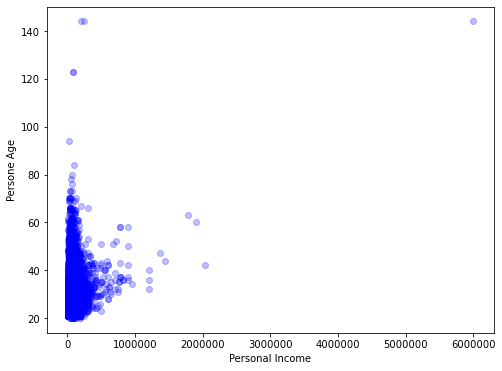

In [41]:
# plots a scatter plot of income against age
plt.figure(figsize=(8, 6))

plt.scatter(df_cr_loan['person_income'], df_cr_loan['person_age'], color='blue', alpha=0.25)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')

# prevents scientific notation on axis
plt.ticklabel_format(useOffset=False, style='plain')

plt.show()

### 4.4.2 Finding outliers with cross tables

In [42]:
# creates the cross table for loan status, home ownership, and the max employment length
pd.crosstab(df_cr_loan['loan_status'],df_cr_loan['person_home_ownership'],
        values=df_cr_loan['person_emp_length'], aggfunc='max')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
False,123.0,24.0,31.0,41.0
True,34.0,11.0,17.0,123.0


It may not be possible for a person to have an employment length of less than `0` or greater than `60`. We can use cross tables to check the data and see if there are any instances of this!

In [43]:
# creates an array of indices where employment length is greater than 60
indices = df_cr_loan[df_cr_loan['person_emp_length'] > 60].index
indices

Int64Index([0, 210], dtype='int64')

In [44]:
# checks how many records presents employment length greater than 60
len(indices)

2

In [45]:
# checks which records will be dropped
df_cr_loan.loc[[0, 210]]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,True,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,False,0.10,N,4


In [46]:
# drops the records from the data based on the indices and create a new dataframe
df_cr_loan_new = df_cr_loan.drop(indices)

### 4.4.3 Visualizing credit outliers

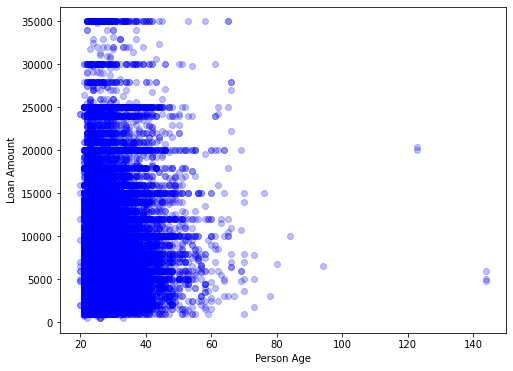

In [47]:
# creates the scatter plot for age and amount
plt.figure(figsize=(8, 6))
plt.scatter(df_cr_loan_new['person_age'], df_cr_loan_new['loan_amnt'], color='blue', alpha=0.25)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

In [48]:
# uses pandas to drop the record from the data frame and create a new one
df_cr_loan_new = df_cr_loan_new.drop(df_cr_loan_new[df_cr_loan_new['person_age'] > 100].index)

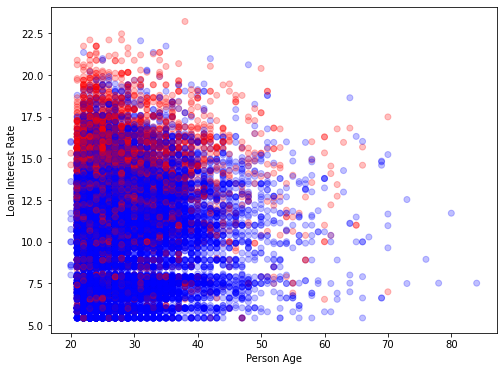

In [49]:
# creates a scatter plot of age and interest rate
colors = ["blue","red"]
plt.figure(figsize=(8, 6))
plt.scatter(df_cr_loan_new['person_age'], df_cr_loan_new['loan_int_rate'],
            c = df_cr_loan_new['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.25)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

## 4.5 Checking missing data

### 4.5.1 Replacing missing credit data

In [50]:
# overwrites the raw data set
df_cr_loan = df_cr_loan_new.copy()

In [51]:
# prints the cols that contain null values
df_cr_loan.columns[df_cr_loan.isnull().any()]

Index(['person_emp_length', 'loan_int_rate'], dtype='object')

In [52]:
# checks how many null records for each column 
df_cr_loan.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3115
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [53]:
# prints the top five rows with nulls for employment length
df_cr_loan[df_cr_loan['person_emp_length'].isnull()].head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
105,22,12600,MORTGAGE,NaN,PERSONAL,A,2000,5.42,True,0.16,N,4
222,24,185000,MORTGAGE,NaN,EDUCATION,B,35000,12.42,False,0.19,N,2
379,24,16800,MORTGAGE,NaN,DEBTCONSOLIDATION,A,3900,NaN,True,0.23,N,3
407,25,52000,RENT,NaN,PERSONAL,B,24000,10.74,True,0.46,N,2
408,22,17352,MORTGAGE,NaN,EDUCATION,C,2250,15.27,False,0.13,Y,3


We can use several different functions like `mean()` and `median()` to replace missing data. The goal here is to keep as much of our data as we can! It's also important to check the distribution of that feature to see if it changed.

In [54]:
# imputes the null values with the median value for all employment lengths
df_cr_loan['person_emp_length'].fillna((df_cr_loan['person_emp_length'].median()), inplace=True)

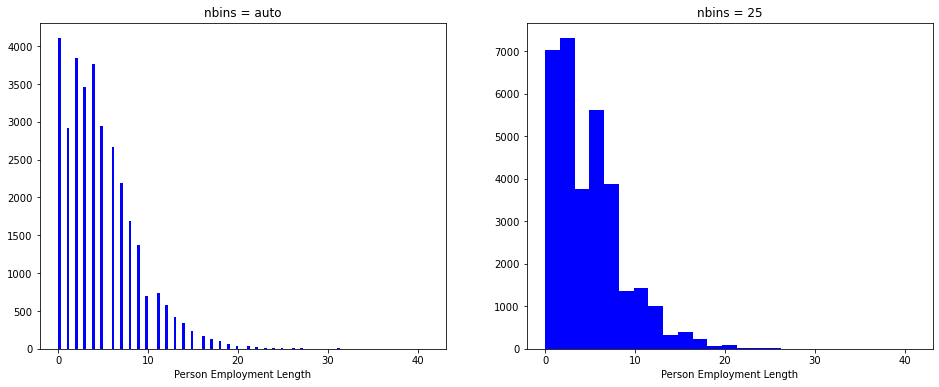

In [55]:
# creates a histogram of employment length
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
n, bins, patches = plt.hist(df_cr_loan['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.title("nbins = auto")

plt.subplot(1,2,2)
n, bins, patches = plt.hist(df_cr_loan['person_emp_length'], bins=25, color='blue')
plt.xlabel("Person Employment Length")
plt.title("nbins = 25")

plt.show()

### 4.5.2 Removing missing data

In [56]:
# prints the number of nulls
print(df_cr_loan['loan_int_rate'].isnull().sum())

3115


In [58]:
# stores the array on indices
indices = df_cr_loan[df_cr_loan['loan_int_rate'].isnull()].index

# saves the new data without missing data
df_cr_loan_clean = df_cr_loan.drop(indices)

 Now that the missing data and outliers have been processed, the data is ready for modeling! More often than not, financial data is fairly tidy, but it's always good to practice preparing data for analytical work.

In [59]:
# counts the number of records for each unique value
df_cr_loan_clean['person_home_ownership'].value_counts()

RENT        14890
MORTGAGE    12119
OWN          2356
OTHER          94
Name: person_home_ownership, dtype: int64

In [60]:
# checks the cleaned data set
df_cr_loan_clean.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

## 4.6 Checkpoint

In [35]:
# saves the data set state
#df_cr_loan_clean.to_csv('data/cr_loan_clean.csv', index=False)

# Creating hypotheses

### 5.2.1 Person Age

1. There are more defaults for young people.

### 5.2.2 Person Income

1. People who default have lower income than people who not default.
2. People who allocate higher percentage of income to the loan tend to default more than people who allocate less.

### 5.2.3 Home ownership

1. Mortgage have more cases of default, followed by rent and own.

### 5.2.4 Employment Length

1. The are fewer cases of default for people with long employment length.

### 5.2.5 Default on file

1. There are more cases of default for people having history of default.

### 5.2.6 Credit history length

1. There are fewer cases of default for people having longer credit history length.

### 5.2.7 Loan intent

1. There are more cases of default for personal, followed by education, medical, home improvement and debt consolidation.
2. The least cases of default are for venture.

### 5.2.8 Loan grade

1. The higher the grade, the fewer are the cases of default.

### 5.2.9 Loan amount

1. The amount median for default cases is higher than for non-default.

### 5.2.10 Loan interest rate

1. The higher the interest rate, the higher is the number of default cases.

# 6.0 Exploratory data analysis

## 6.1 Loading data set

In [64]:
df_cr_loan = df_cr_loan_clean
df_cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,False,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,True,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,True,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,True,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,True,0.25,N,2


In [65]:
# checks the size
df_cr_loan.shape

(29459, 12)

## 6.2 Univariate analysis

### 6.2.1 Target variable

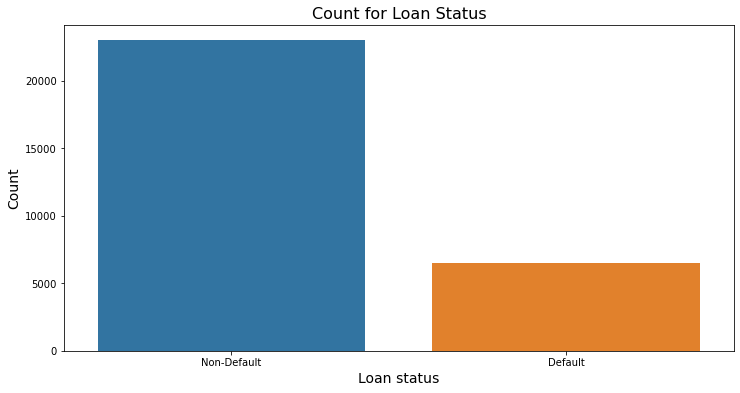

In [66]:
# plots count
ax = sns.countplot(x=df_cr_loan['loan_status'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# set plot features
ax.set_title("Count for Loan Status", fontsize=16)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Loan status", fontsize=14)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# displays plot
plt.show()

In [67]:
# separating the data set for easier analysis
df_default = df_cr_loan[df_cr_loan['loan_status'] == 1].copy()
df_non_default = df_cr_loan[df_cr_loan['loan_status'] == 0].copy()

In [68]:
# counts the number of defaults and non-defaults
total_default = df_default.shape[0]
total_non_default = df_non_default.shape[0]
total_loans = df_cr_loan.shape[0]

print('Number of default cases:', total_default)
print('This is equivalent to {:.2f}% of the total loans'.format((total_default/total_loans)*100))

print('\nNumber of non-defualt cases:', total_non_default)
print('This is equivalent to {:.2f}% of the total loans'.format((total_non_default/total_loans)*100))

Number of default cases: 6463
This is equivalent to 21.94% of the total loans

Number of non-defualt cases: 22996
This is equivalent to 78.06% of the total loans


### 6.2.2 Numerical variables

In [72]:
# creates a dataset for numerical attributes
num_attributes = df_cr_loan.select_dtypes(include=['int32', 'float64', 'bool'])

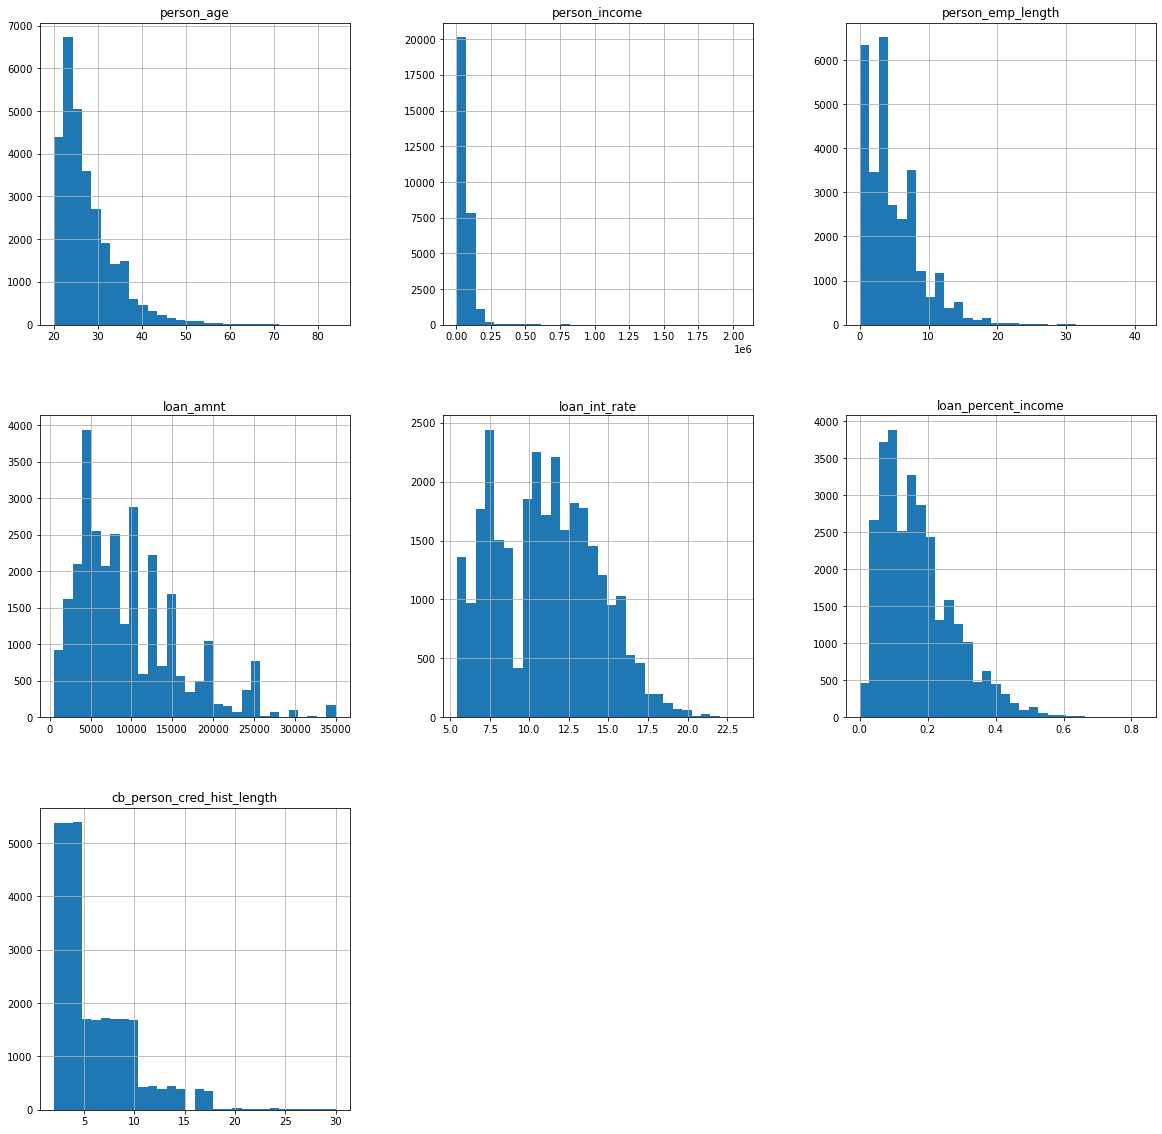

In [73]:
# plots a histogram for all numerical attributes
_ = num_attributes.hist(bins=30, figsize=(20,20))

### 6.2.3 Categorical variables

In [74]:
# creates a dataset for categorical attributes
cat_attributes = df_cr_loan.select_dtypes(exclude=['int32', 'float64', 'bool'])

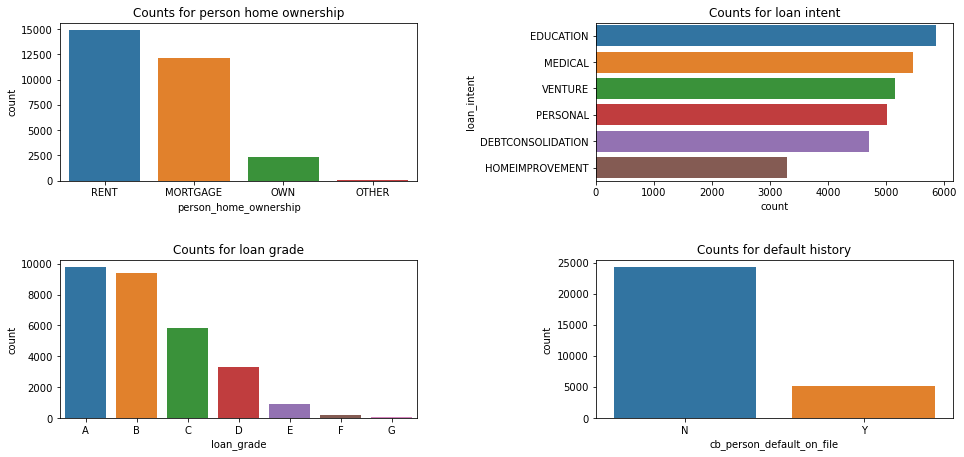

In [75]:
# uses the variable ax for a single Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 16)

# person_home_ownership
plt.subplot(4, 2, 1)
sns.countplot(x=cat_attributes['person_home_ownership'], 
              order=cat_attributes['person_home_ownership'].value_counts().index)
plt.title("Counts for person home ownership")

# loan_intent
plt.subplot(4, 2, 2)
sns.countplot(y=cat_attributes['loan_intent'], 
              order=cat_attributes['loan_intent'].value_counts().index)
plt.title("Counts for loan intent")

# loan_grade
plt.subplot(4, 2, 3)
sns.countplot(x=cat_attributes['loan_grade'], 
              order=cat_attributes['loan_grade'].value_counts().index)
plt.title("Counts for loan grade")

# cb_person_default_on_file
plt.subplot(4, 2, 4)
sns.countplot(x=cat_attributes['cb_person_default_on_file'], 
              order=cat_attributes['cb_person_default_on_file'].value_counts().index)
plt.title("Counts for default history")

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.5)

# display plots
plt.show()

## 6.3 Bivariate analysis - Hypotheses validation

In this section, we're going to validate the hypotheses that we outlined in section 5.

### H1. There are more defaults for young people. <font color='green'>(TRUE)

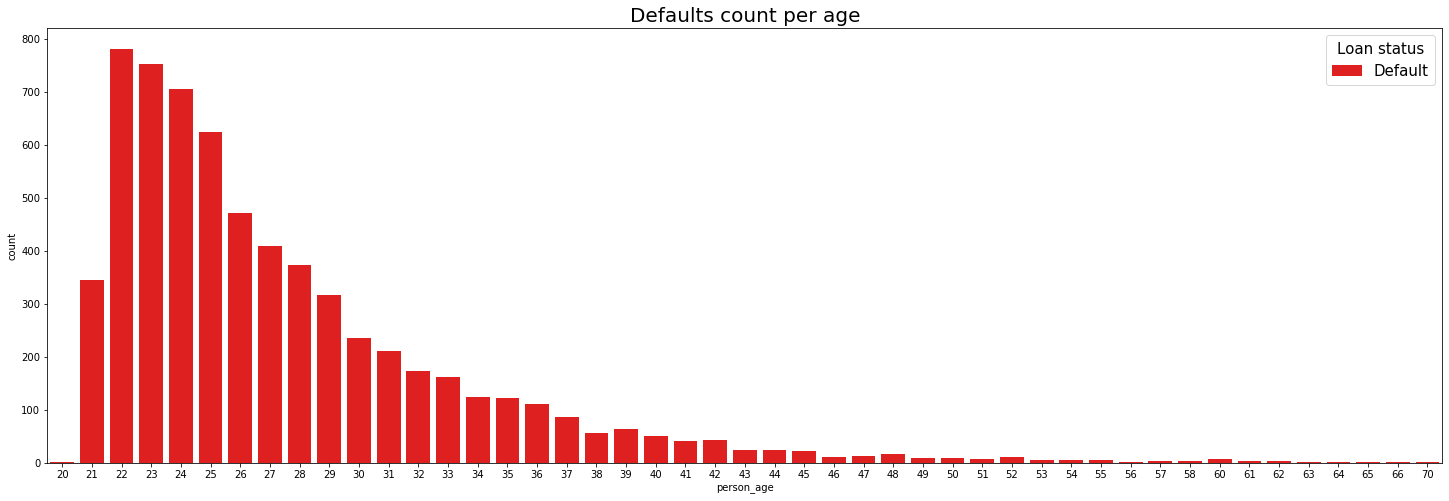

In [76]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='person_age', hue='loan_status', data=df_default, palette=["r"])

# sets plot title
ax.set_title("Defaults count per age", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, there are more deault cases for people at young age (up to 40s).

> Thus, the hypothesis is **TRUE**.

### H2. People who default have lower income than people who not default. <font color='green'>(TRUE)

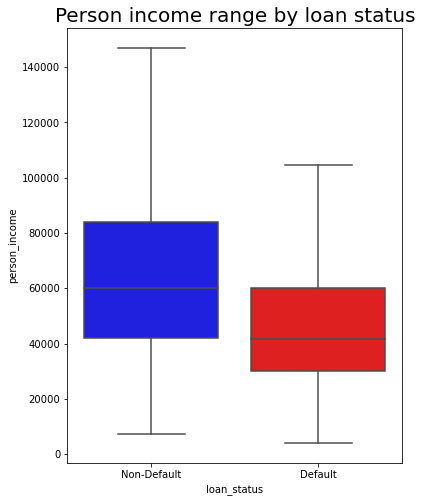

In [77]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(6, 8)

# plots the graph
sns.boxplot(x='loan_status', y='person_income',  data=df_cr_loan, showfliers=False, palette=["b", "r"])

# sets plot title
ax.set_title("Person income range by loan status", fontsize=20)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# display plots
plt.show()

As observed, the mean income for people who default is lower than for people who don't.

> Thus, the hypothesis is **TRUE**.

### H3. The median percentage of income to the loan is higher for default than the median for non-default. <font color='green'>(TRUE)

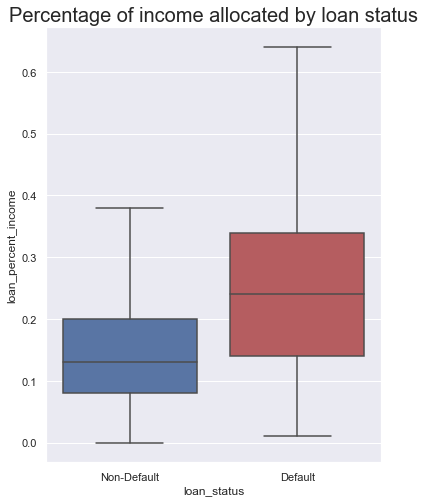

In [47]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(6, 8)

# plots the graph
sns.boxplot(x='loan_status', y='loan_percent_income',  data=df_cr_loan, 
            showfliers=False, palette=["b", "r"])

# sets plot title
ax.set_title("Percentage of income allocated by loan status", fontsize=20)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# display plots
plt.show()

As observed, the median of the percentage of income allocated is higher for people who default than for the people who don't.

> Thus, the hypothesis is **TRUE**.

### H4. Mortgage have more cases of default, followed by rent and own. <font color='red'>(FALSE)

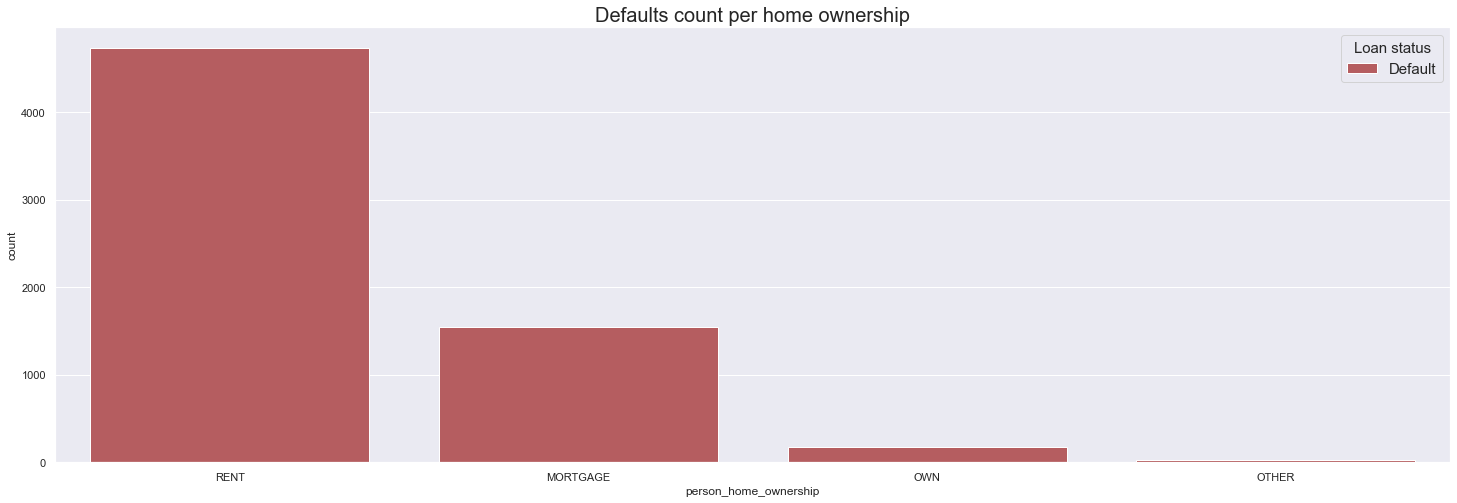

In [48]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='person_home_ownership', hue='loan_status', data=df_default, 
              order=df_default['person_home_ownership'].value_counts().index, palette=["r"])

# sets plot title
ax.set_title("Defaults count per home ownership", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, `RENT` is the top home ownership type for people who default, not `MORTGAGE`.

> Thus, the hypothesis is **FALSE**.

### H5. The are fewer cases of default for people with long employment length. <font color='green'>(TRUE)

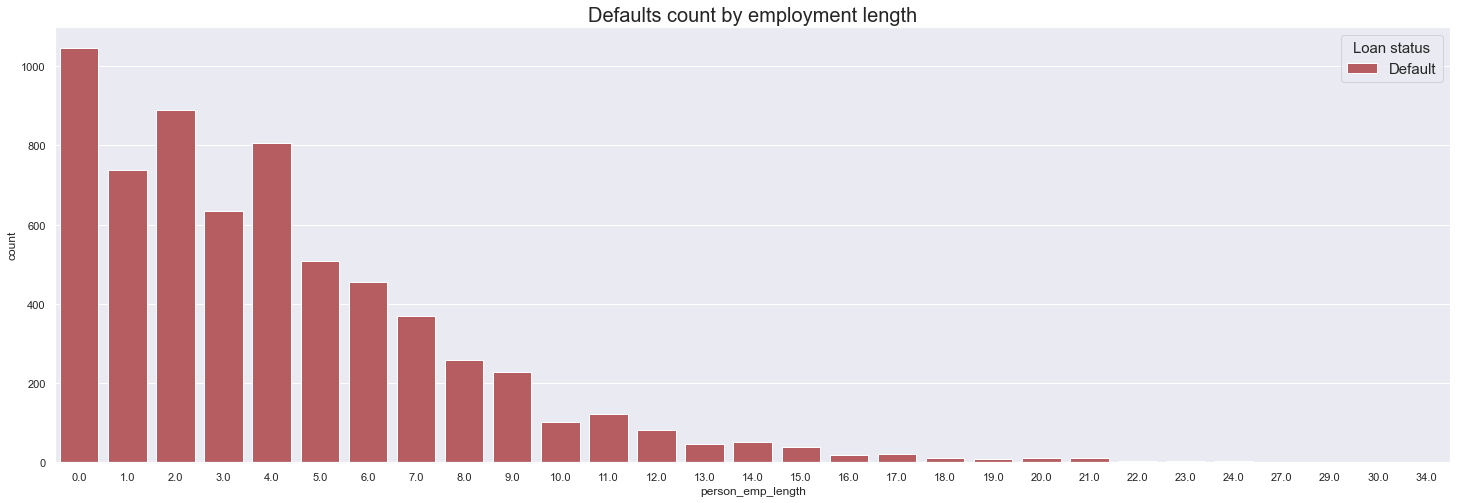

In [49]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='person_emp_length', hue='loan_status', data=df_default, palette=["r"])

# sets plot title
ax.set_title("Defaults count by employment length", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, the are fewer cases of default for people with long employment length that for people in the early years.

> Thus, the hypothesis is **TRUE**.

### H6. There are more cases of default for people having history of default. <font color='red'>(FALSE)

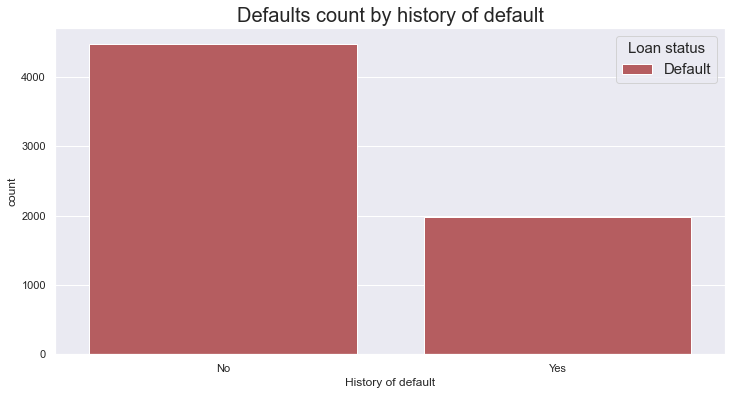

In [50]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# plots the graph
sns.countplot(x='cb_person_default_on_file', hue='loan_status', data=df_default, palette=["r"])

# sets plot title
ax.set_title("Defaults count by history of default", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

plt.xlabel("History of default")

# set xticks labels
plt.xticks([0, 1], ['No', 'Yes'])

# display plots
plt.show()

As observed, there are more cases of default for people who don't have history of default.

> Thus, the hypothesis is **FALSE**.

### H7. There are fewer cases of default for people having longer credit history length. <font color='green'>(TRUE)

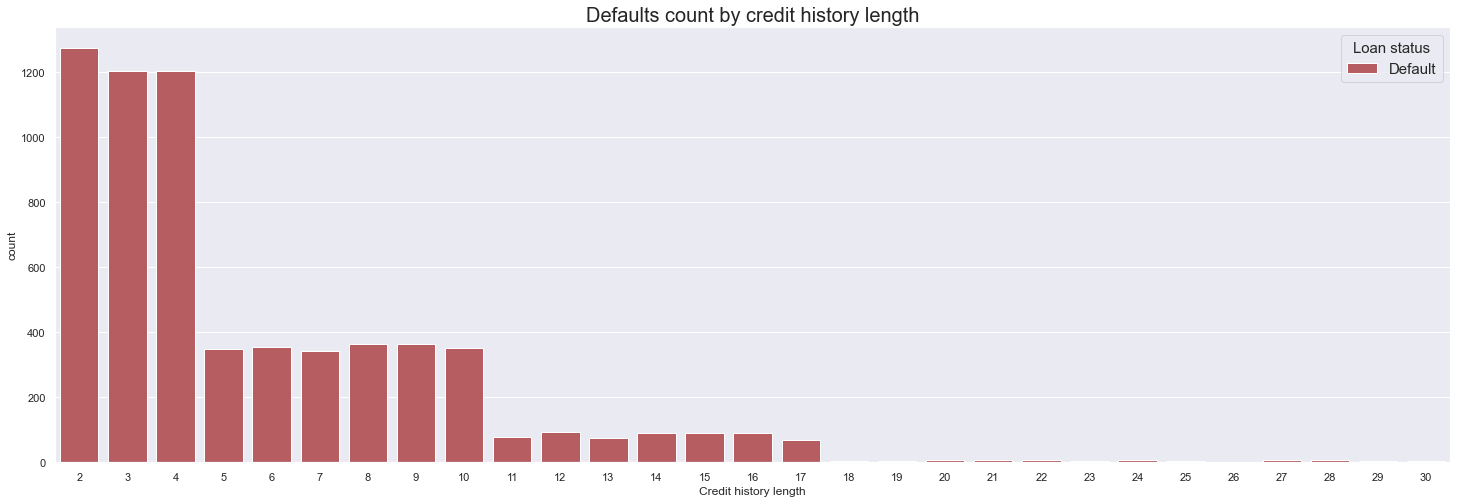

In [51]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='cb_person_cred_hist_length', hue='loan_status', data=df_default, palette=["r"])

# sets plot title
ax.set_title("Defaults count by credit history length", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

plt.xlabel("Credit history length")

# display plots
plt.show()

As observed, there are fewer cases of default for people having longer credit history length.

> Thus, the hypothesis is **TRUE**.

### H8. There are more cases of default for personal than any other intent. <font color='red'>(FALSE)</font>
### H9. The least cases of default are for venture. <font color='green'>(TRUE)

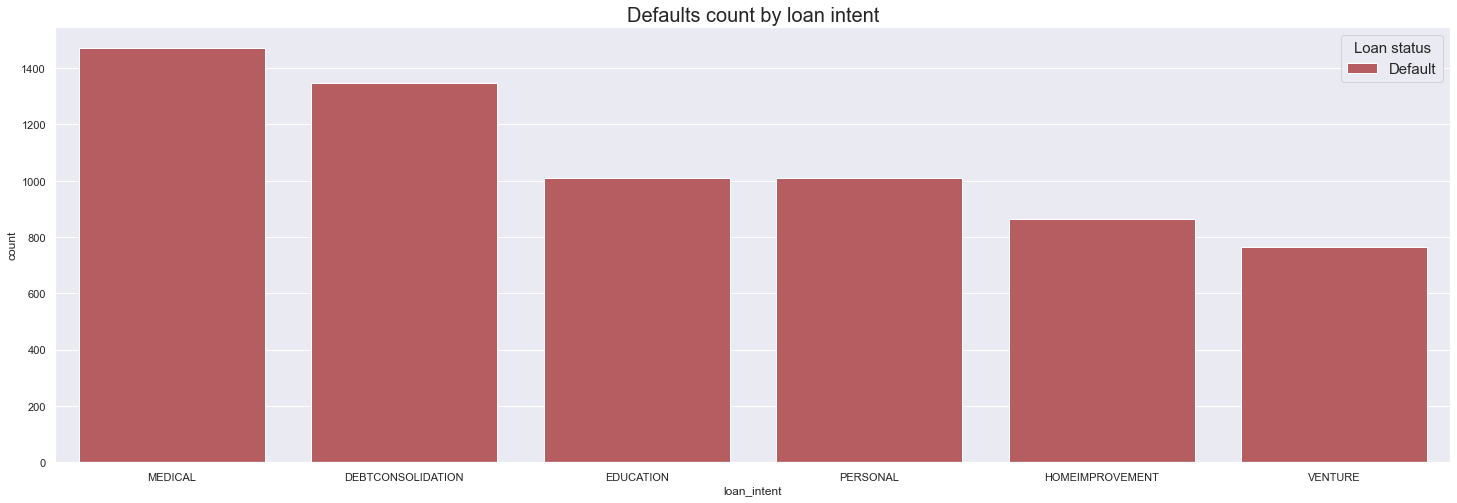

In [52]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='loan_intent', hue='loan_status', data=df_default, 
              order=df_default['loan_intent'].value_counts().index, palette=["r"])

# sets plot title
ax.set_title("Defaults count by loan intent", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, `MEDICAL` holds the most number of default cases and `VENTURE` the least.

> Thus, the hypothesis is **FALSE**.

### H10. The higher the grade, the fewer are the cases of default. <font color='red'>(FALSE)

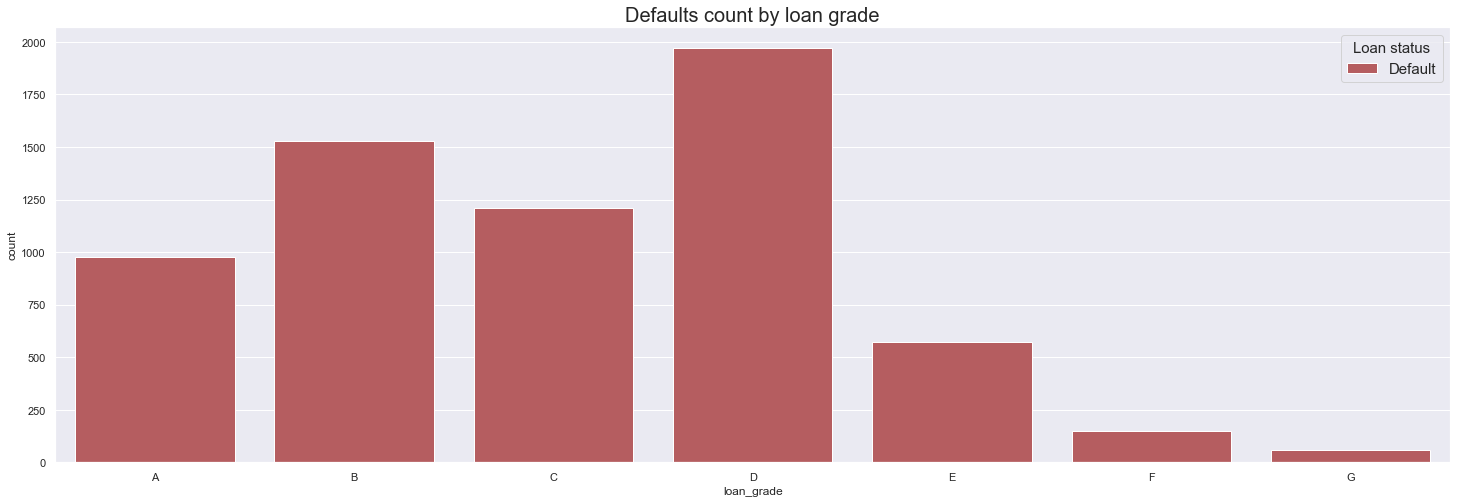

In [53]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='loan_grade', hue='loan_status', data=df_default, 
              order=df_default['loan_grade'].value_counts().index.sort_values(), palette=["r"])

# sets plot title
ax.set_title("Defaults count by loan grade", fontsize=20)

# sets the legend
plt.legend(title="Loan status", labels=['Default'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, despite the grade `D` that is right at the middle grade, the higher the loand grade, the higher is the number of default cases.

> Thus, the hypothesis is **FALSE**.

### H11. The loan amount median for default cases is higher than for non-default. <font color='green'>(TRUE)

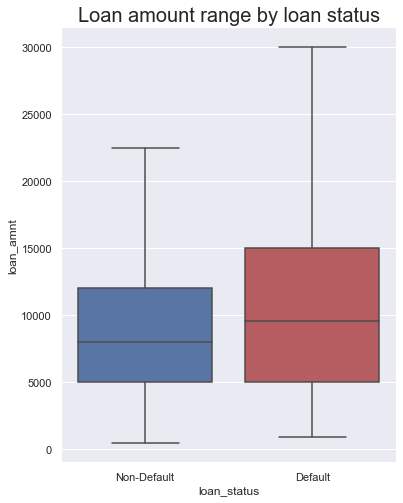

In [54]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(6, 8)

# plots the graph
sns.boxplot(x='loan_status', y='loan_amnt',  data=df_cr_loan, showfliers=False, palette=["b", "r"])

# sets plot title
ax.set_title("Loan amount range by loan status", fontsize=20)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# display plots
plt.show()

As observed, the loan amount median for default cases is higher than for non-default.

> Thus, the hypothesis is **TRUE**.

### H12. The interest rate median for default cases is higher than for non-default. <font color='green'>(TRUE)

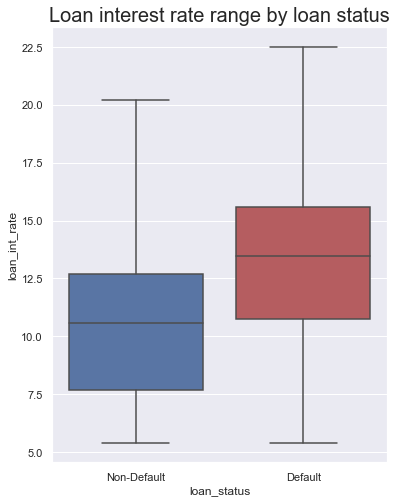

In [55]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(6, 8)

# plots the graph
sns.boxplot(x='loan_status', y='loan_int_rate',  data=df_cr_loan, showfliers=False, palette=["b", "r"])

# sets plot title
ax.set_title("Loan interest rate range by loan status", fontsize=20)

# set xticks labels
plt.xticks([0, 1], ['Non-Default', 'Default'])

# display plots
plt.show()

As observed, the interest rate median for default cases is higher than for non-default.

> Thus, the hypothesis is **TRUE**.

## 6.4 Multivariate analysis - Correlations

### 6.4.1 Correlation between numerical attributes (explanatory vars)

In [56]:
# drops target var
num_attributes = num_attributes.drop('loan_status', axis=1)

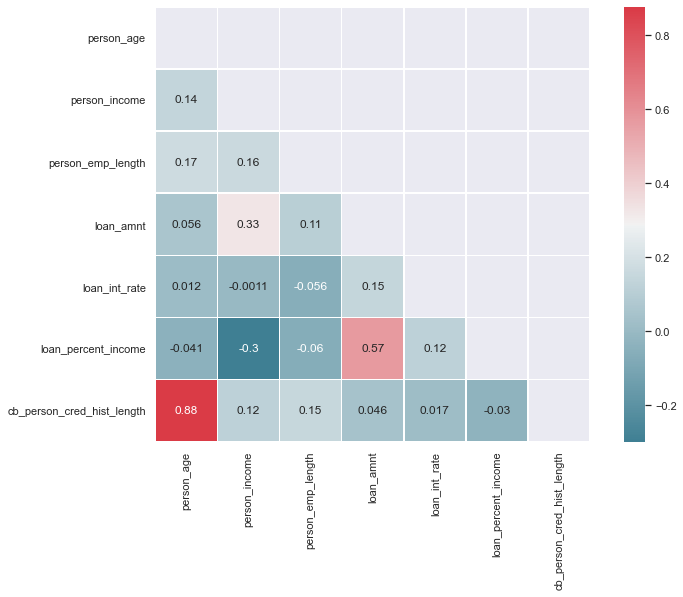

In [57]:
# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 8)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=np.bool))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlation, cmap=cmap, mask=mask, square=True, linewidths=.5, annot=True)

# displays the plot
plt.show()

### 6.4.2 Correlations between categorical attributes (explanatory vars)

In [58]:
# creates a dataset for categorical attributes
cat_attributes = df_cr_loan.select_dtypes(exclude=['int64', 'float64'])

#### Using Cramer V

In [59]:
# gets the cramer list of calculated values
cramer_list = gu.get_cramer_list(cat_attributes)

# builds the dataset to make the correlations
cat_corr = pd.DataFrame({'person_home_ownership': cramer_list[0],
                  'loan_intent': cramer_list[1],
                  'loan_grade': cramer_list[2],
                  'cb_person_default_on_file': cramer_list[3]
                 })

# sets index equal to columns
cat_corr = cat_corr.set_index(cat_corr.columns)

#### Using Theil's U

In [60]:
# gets the theils_u list of calculated values
theils_u_list = gu.get_theils_u_list(cat_attributes)

# builds the dataset to make the correlations
cat_corr_tu = pd.DataFrame({'person_home_ownership': theils_u_list[0],
                  'loan_intent': theils_u_list[1],
                  'loan_grade': theils_u_list[2],
                  'cb_person_default_on_file': theils_u_list[3]
                 })

# sets index equal to columns
cat_corr_tu = cat_corr_tu.set_index(cat_corr_tu.columns)

#### Analyzing the correlation methods

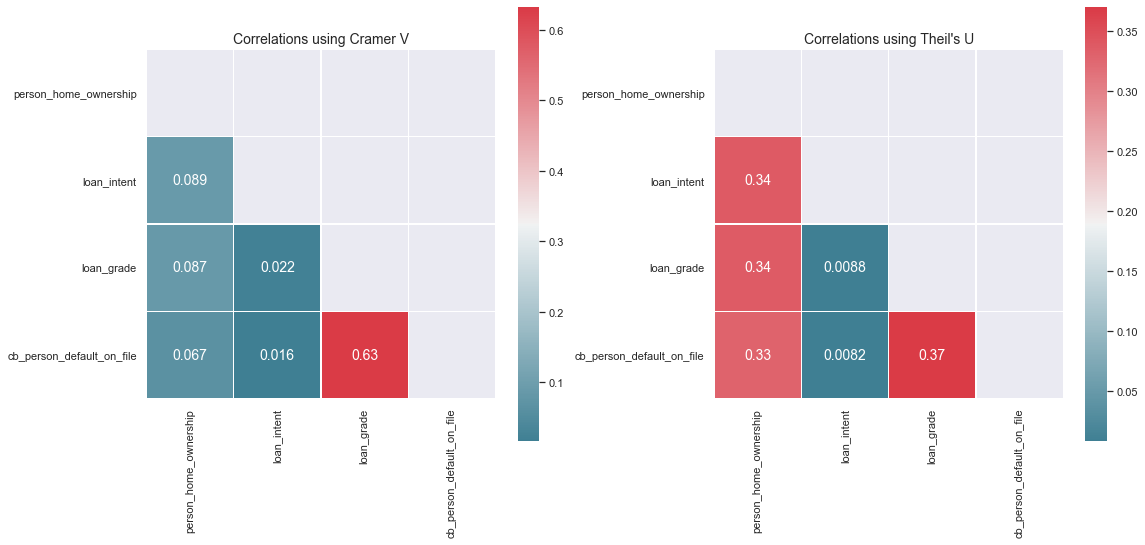

In [61]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(18, 8)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(cat_corr, dtype=np.bool))
mask = np.triu(np.ones_like(cat_corr_tu, dtype=np.bool))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
plt.subplot(1,2,1)
sns.heatmap(cat_corr, cmap=cmap, mask=mask, square=True, linewidths=.5, annot=True, annot_kws={"size":14})
plt.title("Correlations using Cramer V", fontsize=14)

plt.subplot(1,2,2)
sns.heatmap(cat_corr_tu, cmap=cmap, mask=mask, square=True, linewidths=.5, annot=True, annot_kws={"size":14})
plt.title("Correlations using Theil's U", fontsize=14)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.3)

# displays the plot
plt.show()

# 7.0 Data preprocessing